# Portfolio Analytics:

* This notebook intends to analyze and compare the performance of bonds versus tail risk strategies as part of a portfolio that has exposure to equity beta i.e. S&P500. I compare the two portfolios (one which combines bonds and stocks versus another which combines tail-risk hedge category of strategies with stocks) and weight the underlying assets using a risk-parity approach (since that is the most widely known and popularized application to the stock-bond portfolio). More details on this below.


* The hypothesis here is that bonds will not be as much of an effective hedge (due to higher correlation during liquidity events/dash for cash and as rates keep moving lower to the ZLB, the risks from duration outweigh the rewards) and cannot provide the explosive and convex return during huge market drawdown events.  Long-Only Momentum (in STIRS/ global bond futures) and implied volatility exposure (which is structurally negatively correlated to the broader equity markets) can prove to be better hedges, allowing the investors to take on more risks. 


* This is supposed to be a simple exercise with naive proxies for tail-risk hedge exposure to explore the concept and is not a primer on how to get long volatility exposure in your portfolio, since constructing such exposures will require active management and lots of expertise. 


* This is a follow-up to my earlier post on LinkedIn which you can [find here](https://www.linkedin.com/feed/update/urn:li:activity:6692831848864768000/). It borrows an interesting quote from Artemis Capital's note (see below) and explores it further.


> "Anti-correlation is worth more than excess return."



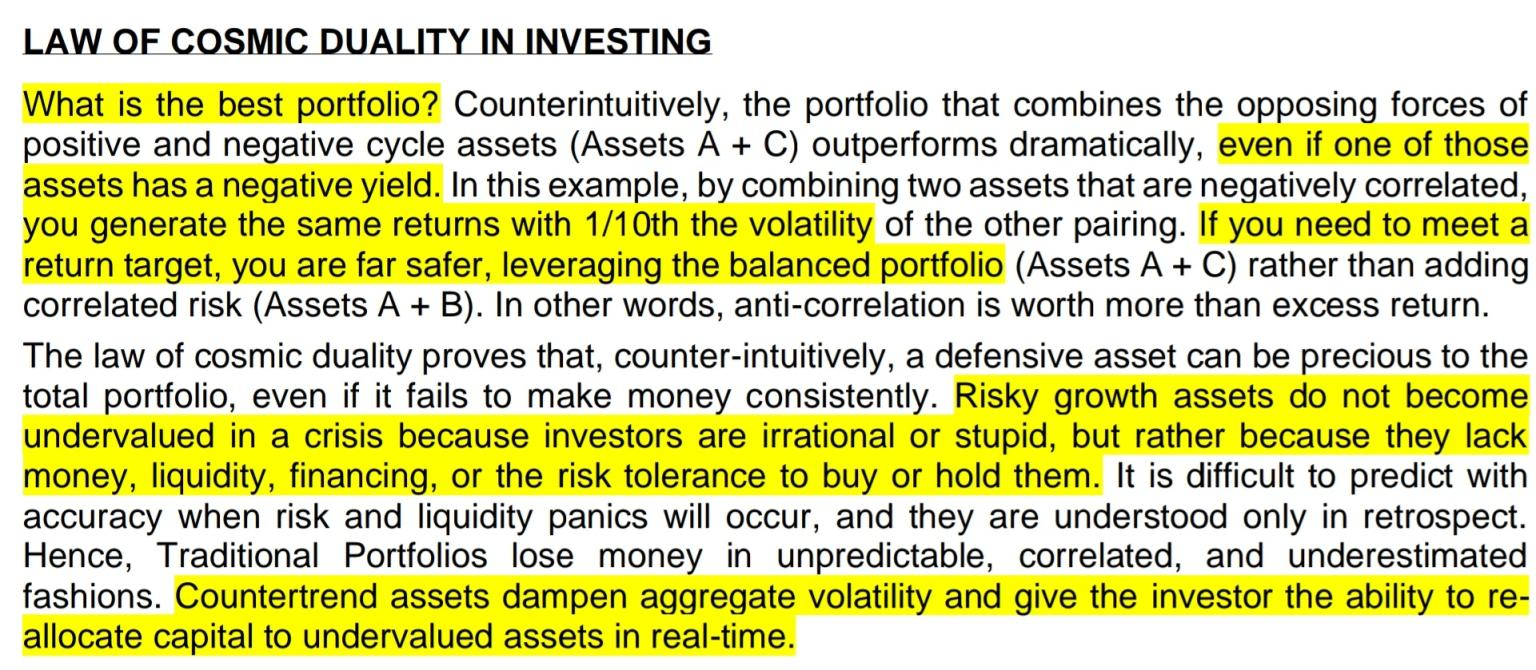

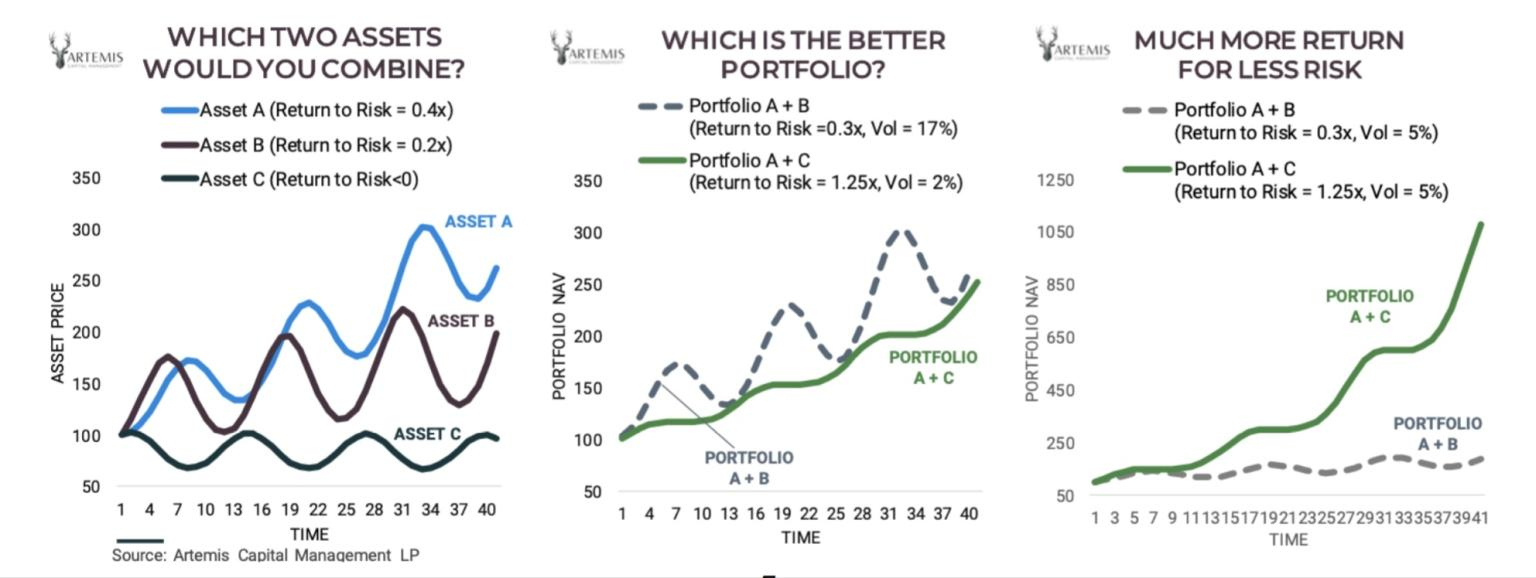

<u> **The two portfolios under consideration in our exercise are as follows:** </u>


- **Long Duration RP Portfolio** targets a  Risk-Parity weighted exposure to Long Term US Treasuries Total Return Index by Bloomberg (similar to TLT/EDV ETFs) and the S&P500.


- **Tail Risk RP Portfolio** targets a Risk-Parity weighted exposure to STIRS/Bond Futures Long Only Momentum, Implied Volatility (VIX)  and the S&P500.

P.S: I do not recommend deploying a Risk-Parity approach in a traditional cross-asset portfolio.

In [512]:
import numpy as np
import pandas as pd
import edhec_risk_kit as erk
import matplotlib.pyplot as plt
import yfinance as yf

import plotly.express as px
import plotly

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [367]:
#Import Data

df = pd.read_excel('dd.xlsx', header=0, index_col=0, parse_dates=True)
vix = yf.download('^VIX', progress=False)['Adj Close']
vix = pd.DataFrame(vix)
vix.columns = ['Volatility']
df = df.merge(vix['Volatility'], on='Date')
data = df.drop('VIX Futures', axis=1).dropna()
rets = data.pct_change().dropna()

## Basic Summary Stats: March 2000 - July 2020

The following are th four assets/securities/strategies considered:

-  **Tail Risk** refers to the STIRS/Bond Futures Long Only Momentum (CSTSERUS-Bloomberg Ticker), **Volatility** refers to S&P500 VIX (Exposure can be taken via VIX Futures or VXX ETF, etc, I have used VIX index here since it had a much longer history, hence, actual performance can differ). These two combined with S&P500 form a part of the **Tail Risk Risk Parity (RP) Portfolio**.


- **UST Long** refers to the Long Term US Treasuries Total Return Index by Bloomberg (Exposure can be taken via direct bond purchases or TLT/EDV/ZROZ ETFs). This combined with S&P500 form a part of the **Long Duration Risk Parity (RP) Portfolio**.

In [368]:
#Basic Summary Stats - 2000 to 2020
erk.summary_stats(rets, 0, 252).sort_values(by='Sharpe Ratio', ascending=False).T

Tail Risk UST Long   S&P500 Volatility
Total Return               384.0%   373.3%  217.33%      7.53%
Annualized Return           8.37%    8.26%    6.09%      0.35%
Annualized Vol              8.29%   12.03%    20.2%    119.39%
Skewness                     0.39     -0.1    -0.19       2.06
Kurtosis                    21.08     7.93    13.59      20.43
Cornish-Fisher VaR (5%)     0.57%    1.16%    1.86%      4.45%
Historic CVaR (5%)          1.25%    1.68%    3.07%     13.13%
Sharpe Ratio                 1.01     0.69      0.3          0
Sortino Ratio                1.17     0.98     0.38       0.01
Max Drawdown              -13.13%   -18.4%  -55.25%     -88.7%

In [450]:
fig = px.line(((1+rets['2000':]).cumprod()-1).dropna())
fig.update_layout(title = 'Performance: March, 2000 - July, 2020',
                   xaxis_title='Date',
                   yaxis_title='Returns (%)', font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                   legend_title_text='Securities', plot_bgcolor = 'White', yaxis_tickformat = '%')
fig.update_traces(hovertemplate='Date: %{x} <br>Return: %{y:.2%}') 

In [463]:
period = 126
fig = px.line(data.pct_change(period).dropna())
fig.update_layout(title = 'Rolling Six Month Returns',
                   xaxis_title='Date',
                   yaxis_title='Returns (%)', font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                   legend_title_text='Securities', plot_bgcolor = 'White', yaxis_tickformat = '%')
fig.update_traces(hovertemplate='Date: %{x} <br>Return: %{y:.2%}') 

In [523]:
mrets = rets.resample("M").apply(lambda x: ((x + 1).cumprod() - 1).last("D"))
def scatter(sec):
    if sec=='Volatility':
        fig = px.scatter(mrets[[sec, 'S&P500']], y=sec, x='S&P500', 
                     hover_name=mrets.index.strftime("%b %Y"), trendline="ols", color_continuous_scale='rdylgn')
    else:
        fig = px.scatter(mrets[[sec, 'S&P500']], y=sec, x='S&P500', range_x=(-0.15,0.15), range_y=(-0.15,0.15), 
                     hover_name=mrets.index.strftime("%b %Y"), trendline="ols", color_continuous_scale='rdylgn')
    
    fig.update_layout(title = 'Monthly Returns Scatter Plot of S&P500 versus ' + sec,
                   font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                   plot_bgcolor = 'White', yaxis_tickformat = '.2%', xaxis_tickformat = '.2%')
    return fig.show()
    
interact(scatter, sec=widgets.Dropdown(options=('Tail Risk', 'UST Long', 'Volatility'), value='UST Long', description='Security: '));

interactive(children=(Dropdown(description='Security: ', index=1, options=('Tail Risk', 'UST Long', 'Volatilit…

## Portfolio Risk Parity Weight Drifts:

**Standard Assumptions**
- Lookback Period: 1 Quarter
- Rebalancing Frequency: Monthly
- Start Date: Sept 2000
- End Date: July 2020

In [519]:
#Generate RP Weights for the two portfolios
#import pybt as bt
#lb = 90
#rebal = 21

#rp_weights1 = bt.SAA.rp_weight_resample(data[['Tail Risk', 'S&P500', 'Volatility']], lb, rebal)
#rp_weights2 = bt.SAA.rp_weight_resample(data[['UST Long', 'S&P500']], lb, rebal)

rp_weights1 = pd.read_excel('tailrisk_weights.xlsx', header=0, index_col=0, parse_dates=True)
rp_weights2 = pd.read_excel('longbond_weights.xlsx', header=0, index_col=0, parse_dates=True)

In [517]:
#Plot Weights Drift
import plotly.express as px

fig = px.area(rp_weights1)
fig.update_layout(title = 'Tail Risk RP Portfolio: Risk-Parity Allocations: Sept 2000- July 2020',
                   xaxis_title='Date',
                   yaxis_title='Allocation (%)', font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                   legend_title_text='Securities', plot_bgcolor = 'White', yaxis_tickformat = '%')
fig.update_traces(hovertemplate='Date: %{x} <br>Allocation: %{y:.2%}') 

In [518]:
fig = px.area(rp_weights2)
fig.update_layout(title = 'Long Duration RP Portfolio: Risk-Parity Allocations: Sept 2000- July 2020',
                   xaxis_title='Date',
                   yaxis_title='Allocation (%)', font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                   legend_title_text='Securities', plot_bgcolor = 'White', yaxis_tickformat = '%')
fig.update_traces(hovertemplate='Date: %{x} <br>Allocation: %{y:.2%}') 

## Portfolio Performance Analytics :

* For Volatility Matched Statistics, I have assumed a straightforward 3% p.a. cost of leverage across the years for simplicity.
* Returns are gross of any expenses or rebalancing costs.

In [501]:
#Tail Risk  - Risk Parity Portfolio Daily

rp_weights1.index.name = 'Date'
rp_tr = rets[['S&P500', 'Tail Risk', 'Volatility']]
rp_tr.columns = ['S&P500-R', 'Tail Risk-R', 'Volatility-R']
rp_tr = rp_tr.join(rp_weights1, on='Date')
rp_tr = rp_tr.ffill().dropna()
rp_tr = pd.DataFrame((rp_tr['S&P500-R']*rp_tr['S&P500'] + rp_tr['Tail Risk-R'] * rp_tr['Tail Risk'] + rp_tr['Volatility-R'] * rp_tr['Volatility']), columns=['Tail Risk - RP Portfolio'])


#Long Duration - Risk Parity Portfolio Daily

rp_weights2.index.name = 'Date'
rp_bond = rets[['S&P500', 'UST Long']]
rp_bond.columns = ['S&P500-R', 'UST Long-R']
rp_bond = rp_bond.join(rp_weights2, on='Date')
rp_bond = rp_bond.ffill().dropna()
rp_bond = pd.DataFrame(rp_bond['S&P500-R']*rp_bond['S&P500'] + rp_bond['UST Long-R'] * rp_bond['UST Long'], columns=['Long Duration - RP Portfolio'])

In [502]:
perfs = rp_tr.merge(rp_bond, on='Date').merge(data['S&P500'].pct_change().dropna(), on='Date')

In [506]:
def sum_stats(cat, start, end):
    if cat=='Yes':
        ratio = perfs['Tail Risk - RP Portfolio'][start:end].std()/perfs['Long Duration - RP Portfolio'][start:end].std()
        ratio2 = perfs['S&P500'][start:end].std()/perfs['Long Duration - RP Portfolio'][start:end].std()
        #return qs.plots.returns(perfs['Tail Risk - RP Portfolio'][start:end], benchmark = perfs['Long Duration - RP Portfolio'][start:end], match_volatility=True)
        perfs1 = perfs.copy()
        perfs1['Tail Risk - RP Portfolio'] = (perfs1['Tail Risk - RP Portfolio']/ratio) - (1-ratio)*0.03/252
        perfs1['S&P500'] = (perfs1['S&P500']/ratio2)  - (1-ratio2)*0.01/252
        return erk.summary_stats(perfs1[start:end], 0, 252).sort_values(by='Sortino Ratio', ascending=False).T
    else:
        return erk.summary_stats(perfs[start:end], 0, 252).sort_values(by='Sortino Ratio', ascending=False).T
    
style = {'description_width': 'initial'} 
interact(sum_stats, cat=widgets.Dropdown(options=('Yes', 'No'), value='Yes', style=style, description='Volatility Matched: '),
                    start = widgets.DatePicker(value=perfs.index[0],style=style, description = 'Start Date: '),
                    end = widgets.DatePicker(value=perfs.index[-1],style=style,  description = 'End Date: '),);

interactive(children=(Dropdown(description='Volatility Matched: ', options=('Yes', 'No'), style=DescriptionSty…

In [520]:
def volm_rets(voladj, start, end):
    if voladj=='Yes':
        ratio = perfs['Tail Risk - RP Portfolio'][start:end].std()/perfs['Long Duration - RP Portfolio'][start:end].std()
        ratio2 = perfs['S&P500'][start:end].std()/perfs['Long Duration - RP Portfolio'][start:end].std()
        #return qs.plots.returns(perfs['Tail Risk - RP Portfolio'][start:end], benchmark = perfs['Long Duration - RP Portfolio'][start:end], match_volatility=True)
        perfs1 = perfs.copy()
        perfs1['Tail Risk - RP Portfolio'] = (perfs1['Tail Risk - RP Portfolio']/ratio) - (1-ratio)*0.03/252
        perfs1['S&P500'] = (perfs1['S&P500']/ratio2)  - (1-ratio2)*0.01/252
        fig = px.line((1+perfs1[start:end]).cumprod()-1, hover_name=perfs1[start:end].index.strftime("%d %b %Y"))
        fig.update_layout(title = 'Performance Comparison: Sept 2000 to July 2020 (Volatility Matched)',
                   xaxis_title='Date',
                   yaxis_title='Return (%)', font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                   legend_title_text='Portfolios', plot_bgcolor = 'White', yaxis_tickformat = '%')
        fig.update_traces(hovertemplate='Date: %{x} <br>Return: %{y:.2%}')
        return fig.show()
    
    else:
        fig = px.line((1+perfs[start:end]).cumprod()-1, hover_name=perfs[start:end].index.strftime("%d %b %Y"))
        fig.update_layout(title = 'Performance Comparison: Sept 2000 to July 2020 (Not Volatility Matched)',
                   xaxis_title='Date',
                   yaxis_title='Return (%)', font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                   legend_title_text='Portfolios', plot_bgcolor = 'White', yaxis_tickformat = '%')
        fig.update_traces(hovertemplate='Date: %{x} <br>Return: %{y:.2%}')
        return fig.show()
    
style = {'description_width': 'initial'} 
interact(volm_rets,
                   start = widgets.DatePicker(value=perfs.index[0],style=style, description = 'Start Date: '),
                   end = widgets.DatePicker(value=perfs.index[-1],style=style,  description = 'End Date: '),
                   voladj = widgets.Dropdown(options=('Yes', 'No'), value='Yes', style=style, description='Volatility Matched: '));

interactive(children=(Dropdown(description='Volatility Matched: ', options=('Yes', 'No'), style=DescriptionSty…

## 1-Year Rolling Correlation of Portfolios with S&P500

It can observed that during volmageddon events like March 2020 the correlation of Long Duration RP Portfolio (Stock/Bond) actually spikes whereas our naive Tail Risk RP Portfolio's correlation takes the complete opposite road and thus adds value.

In [509]:
def roll_corr(period):
    fig = px.line(perfs.rolling(period).corr(perfs['S&P500']).dropna().drop('S&P500', axis=1))
    fig.update_layout(title = 'Rolling ' + str(period) + ' Day Correlation with S&P500',
                       xaxis_title='Date',
                       yaxis_title='Correlation (%)', font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                       legend_title_text='Portfolios', plot_bgcolor = 'White', yaxis_tickformat = '%',
                       xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)

    fig.update_traces(hovertemplate='Date: %{x} <br>Correlation: %{y:.2%}')
    
    return fig.show()

interact(roll_corr, period=widgets.IntSlider(252, 21, 252*3, 21, description = 'Lookback Period: ', style=style));

interactive(children=(IntSlider(value=252, description='Lookback Period: ', max=756, min=21, step=21, style=Sl…

## Monthly Returns Scatter Plot of Portfolios versus S&P500 

<b>
- It can be observed from the monthly return scatter plots of the two portfolios that the Stock-Bond or the Long Duration Risk-Parity Portfolio has a positive linear relationship with the S&P500, whereas on the other hand, our naive Tail Risk Risk-Parity Portfolio has no linear relationship with the S&P500!
<b>

In [521]:
mprets = perfs.resample("M").apply(lambda x: ((x + 1).cumprod() - 1).last("D"))

def scatterm(sec):
    fig = px.scatter(mprets[[sec, 'S&P500']], y=sec, x='S&P500', range_x=(-0.15,0.15), range_y=(-0.15,0.15), 
                     hover_name=mprets.index.strftime("%b %Y"), trendline="ols", color_continuous_scale='rdylgn')
    
    fig.update_layout(title = 'Monthly Returns Scatter Plot of S&P500 versus ' + sec,
                   font=dict(family="Segoe UI, monospace", size=13, color="#7f7f7f"),
                   plot_bgcolor = 'White', yaxis_tickformat = '.2%', xaxis_tickformat = '.2%')
    return fig.show()
    
interact(scatterm, sec=widgets.Dropdown(options=('Tail Risk - RP Portfolio', 'Long Duration - RP Portfolio'), value='Tail Risk - RP Portfolio', description='Portfolio: '));

interactive(children=(Dropdown(description='Portfolio: ', options=('Tail Risk - RP Portfolio', 'Long Duration …

> **Thank you for going through my notebook. If you have any comments or insights, please feel free to connect!**

<figure>
   <a href="https://www.linkedin.com/in/harshshivlani/">
   <img src="https://www.stringerllp.com/uploads/ckeditor/pictures/794/linkedin-button_original.png"></a>
</figure>

In [510]:
#import quantstats as qs

In [511]:
#qs.reports.html(perfs1['Tail Risk - RP Portfolio'], perfs1['Long Duration - RP Portfolio'], output='TR-Bond-RP-Adj-Comps.html', title='Tail Risk RP versus Long Duration RP Tearsheet')
#qs.reports.html(perfs['Tail Risk - RP Portfolio'], perfs['S&P500'], output='TR-S&P-Comps.html', title='Tail Risk RP versus S&P500 Tearsheet')
#qs.reports.html(perfs['Long Duration - RP Portfolio'], perfs['S&P500'], output='Bond-S&P-Comps.html', title='Long Duration versus S&P500 Tearsheet')